# Best mutation on a given background

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import sys
import torch
from matplotlib.patches import Patch

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


# Best mutations on BA.2

In [2]:
BA2='SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
len(BA2)
BA2_SEQ=Proteins_utils.seq2num(BA2)


AA = "ACDEFGHIKLMNPQRSTVWY"

def wrap60(s):
    return "\n".join(s[i:i+60] for i in range(0, len(s), 60))

def write_single_mutants_fasta(wt_seq, out_path="../seq_data/BA2_single_mutants.fasta", prefix="BQ"):
    n_written = 0
    with open(out_path, "w") as f:
        for i, wt in enumerate(wt_seq, start=1):
            if wt not in AA:
                continue  # skip non-canonical sites
            for alt in AA:
                if alt == wt:
                    continue
                mut = f"{wt}{i}{alt}"
                seq = wt_seq[:i-1] + alt + wt_seq[i:]
                f.write(f">{prefix}_{mut}\n{wrap60(seq)}\n")
                n_written += 1
    print(f"Wrote {n_written} single mutants to {out_path}")

# run
write_single_mutants_fasta(BA2, out_path="../seq_data/BA2_single_mutants.fasta", prefix="BQ")


Wrote 3382 single mutants to ../seq_data/BA2_single_mutants.fasta


In [3]:
seqs_batch=Proteins_utils.load_FASTA("../seq_data/BA2_single_mutants.fasta")


In [4]:
import numpy as np
import pandas as pd

AA = "ACDEFGHIKLMNPQRSTVWY"  # canonical set

def generate_single_mutants(wt_seq, aa=AA):
    """Return metadata + seqs in the same order as your FASTA loop."""
    sites, mutants, seqs = [], [], []
    for i, wt in enumerate(wt_seq, start=1):           # 1-based index
        if wt not in aa:
            continue
        for alt in aa:
            if alt == wt:
                continue
            sites.append(i+348)
            mutants.append(alt)
            seqs.append(wt_seq[:i-1] + alt + wt_seq[i:])
    return sites, mutants, seqs

# Build batch
sites, mutants, _ = generate_single_mutants(BA2)


# Assemble DataFrame and write CSV
df_scores = pd.DataFrame({
    "site": sites,
    "mutant": mutants,
})

# Optional: sort by site then mutant for readability
df_scores.sort_values(["site", "mutant"], inplace=True, kind="mergesort")

df_scores

,site,mutant
0,349,A
1,349,C
2,349,D
3,349,E
4,349,F
...,...,...
3377,526,S
3378,526,T
3379,526,V
3380,526,W


In [5]:
site_to_variant = {
    490: "XBB.1",
    486: "BA.2.75.2",
    452: "BA.2.12.1",
    456: "EG.5",
    450: "BA.2.3.20",
    446: "BA.2.75.2",
    460: "BA.2.3.20",
    455: "JN.1",
    444: "BA.2.3.20",
    445:  "BA.2.86",
    403: "BA.2.86"
}
ba2_new_mut = {346, 356, 368, 403, 444, 445, 446, 450, 452, 455, 456, 460, 481, 486, 490}


In [6]:
def max_per_site_from_single_mutants(wt_seq, scores, alphabet=AA):
    L = len(wt_seq)
    # how many mutants per site (19 if canonical WT, else 0 because skipped)
    per_site_counts = []
    for i in range(L):
        wt = wt_seq[i]
        if wt in alphabet:
            per_site_counts.append(len(alphabet) - 1)  # exclude WT
        else:
            per_site_counts.append(0)  # no mutants were generated for non-canonical WT

    expected = sum(per_site_counts)
    if scores.shape[0] != expected:
        raise ValueError(f"Length mismatch: got {scores.shape[0]} scores, expected {expected} "
                         f"from sequence length {L} and generation scheme.")

    # slice scores per site and take max
    out_rows = []
    idx = 0
    for i in range(L):
        wt = wt_seq[i]
        k = per_site_counts[i]
        if k == 0:
            idx += 0
            continue
        site_scores = scores[idx:idx+k]
        idx += k
        out_rows.append({"pos": i + 1+348, "wt": wt, "max_score": float(np.max(site_scores))})

    df = pd.DataFrame(out_rows)
    return df

# No Ab

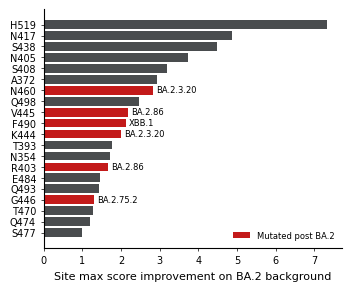

In [7]:
em_path = "../params_by_period_0.03_m1_m8_m8/param_period_2022-01-01.csv"
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS)
model.raw_concentrations=torch.tensor([-10])
scores_diff=score_seq_batch(model, seqs_batch)+model(BA2_SEQ)
df_scores['no_ab']=scores_diff







# Compute table
df_max = max_per_site_from_single_mutants(BA2, scores_diff, alphabet=AA)
# Optional: sort by position
df_max = df_max.sort_values("pos").reset_index(drop=True)

# Compute table
scores_diff = max_per_site_from_single_mutants(BA2, scores_diff, alphabet=AA)
# Optional: sort by position
scores_diff = scores_diff.sort_values("pos").reset_index(drop=True)

# Labels like "A123"
labels = scores_diff.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = scores_diff["max_score"].to_numpy()
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max.nlargest(20, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()


# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8))

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on BA.2 background", fontsize=8)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()




# Small model

In [8]:
em_path = "../params_by_period_0.03_m1_m8_m8/param_period_2022-01-01.csv"
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS)
scores_diff_small=score_seq_batch(model, seqs_batch)+model(BA2_SEQ)
df_scores['small']=scores_diff_small

len(KD_VECTORS.keys())

29

In [9]:
df_max_small = max_per_site_from_single_mutants(BA2, scores_diff_small, alphabet=AA)
df_max_small = df_max_small.sort_values("pos").reset_index(drop=True)
labels = df_max_small.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = df_max_small["max_score"].to_numpy()




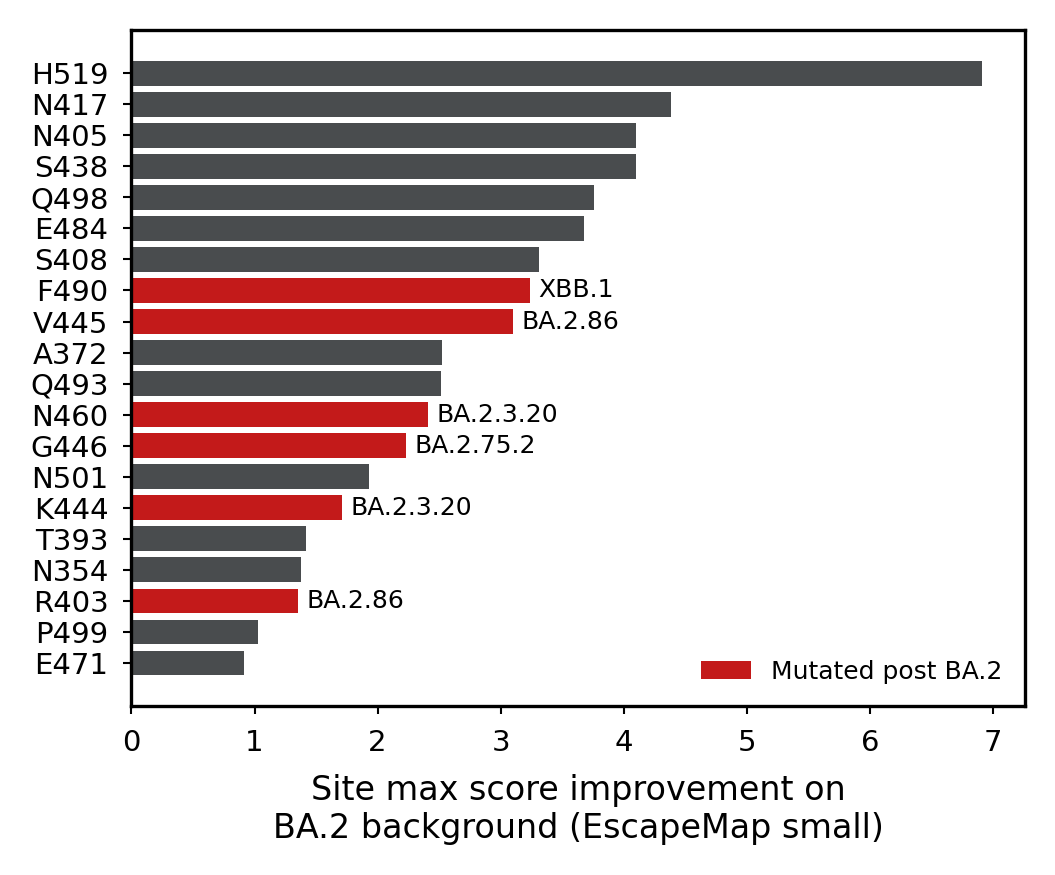

In [10]:
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max_small.nlargest(20, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()




# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8), dpi=300)

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on\nBA.2 background (EscapeMap small)", fontsize=8)

# Clean frame
# for spine in ["top", "right"]:
#     ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()


# FUll model

In [11]:
em_path = "../params_by_period_0.03_m1_m8_m8_full/param_period_2022-01-01.csv"
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS|BA1_KD_VECTORS)
scores_diff_large=score_seq_batch(model, seqs_batch)+model(BA2_SEQ)
df_scores['large']=scores_diff_large
len(BA1_KD_VECTORS.keys())


671

In [12]:
df_max_large = max_per_site_from_single_mutants(BA2, scores_diff_large, alphabet=AA)
df_max_large = df_max_large.sort_values("pos").reset_index(drop=True)
labels = df_max_large.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = df_max_large["max_score"].to_numpy()

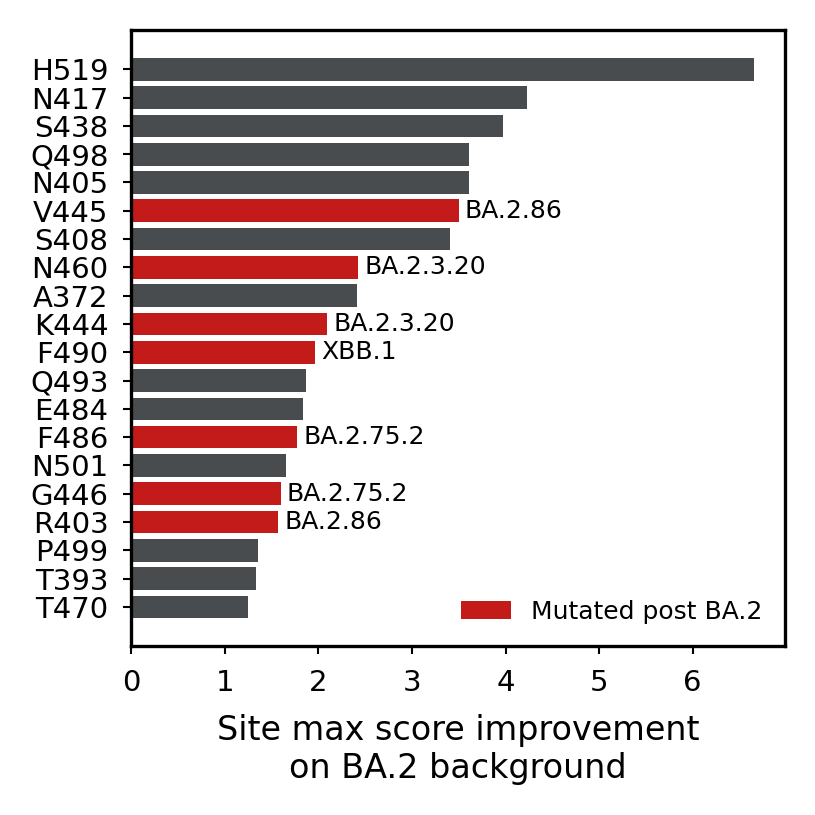

In [13]:
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max_large.nlargest(20, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()

# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

fig, ax = plt.subplots(figsize=(2.6, 2.6), dpi=300)

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement\non BA.2 background", fontsize=8)

# Clean frame
# for spine in ["top", "right"]:
#     ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()


# Next mutations

In [14]:
all_mut=pd.read_csv('../seq_data/all_mutation_summary.csv')
all_mut["first_seen_100"] = pd.to_datetime(all_mut["first_seen_100"], errors="coerce")

mask = (all_mut["first_seen_100"] >= "2022-04-01") & (all_mut["count_100"] >= 100)
all_mut = all_mut.loc[mask].copy()
all_mut

,mutation,count_100,first_seen_100
14,V3F,112,2023-02-02
22,F4L,116,2024-12-06
63,L10I,127,2022-10-12
66,L10V,101,2024-01-24
67,V11A,146,2022-07-05
...,...,...,...
9745,E1258Q,574,2022-04-06
9747,E1258V,165,2022-08-22
9779,E1262K,312,2022-06-19
9818,K1266N,161,2022-08-24


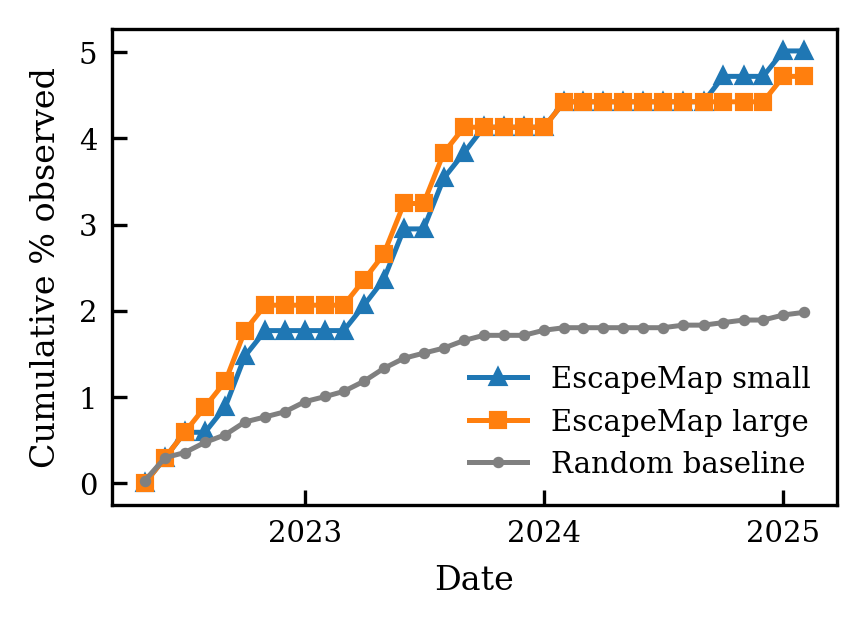

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import re


pat = re.compile(r"^([A-Z])(\d+)([A-Z])$")
def _parse_mut(m):
    if not isinstance(m, str):
        return pd.NA, pd.NA, pd.NA
    m = m.strip()
    mt = pat.match(m)
    if not mt:
        return pd.NA, pd.NA, pd.NA
    wt, pos, mu = mt.groups()
    return wt, int(pos), mu

parsed = all_mut["mutation"].apply(_parse_mut).apply(pd.Series)
parsed.columns = ["wt", "site", "mutant"]
am = pd.concat([all_mut, parsed], axis=1)

# --- Coerce types & dates ---
# --- Coerce, mask, and parse as before ---
am["first_seen_100"] = pd.to_datetime(am["first_seen_100"], errors="coerce")
am.loc[am["count_100"] < 100, "first_seen_100"] = pd.NaT

# ensure types for join
am["site"] = pd.to_numeric(am["site"], errors="coerce").astype("Int64")
am["mutant"] = am["mutant"].astype(str).str.strip()
df = df_scores.copy()
df["site"] = pd.to_numeric(df["site"], errors="coerce").astype("Int64")
df["mutant"] = df["mutant"].astype(str).str.strip()

# --- NEW: collapse duplicates on the right by (site, mutant) ---
# If multiple entries map to the same (site, mutant), take the earliest observed date.
am_collapsed = (
    am[["site", "mutant", "first_seen_100"]]
    .groupby(["site", "mutant"], as_index=False)
    .agg(first_seen_100=("first_seen_100", "min"))
)

# --- Safe many-to-one merge now ---
merged = df.merge(
    am_collapsed,
    on=["site", "mutant"],
    how="left",
    validate="m:1",
)


# --------- Parameters ----------
th = 90  # percentile threshold
score_cols = [ "small", "large"]

# --------- Thresholds (top 10%) ----------
thr = {c: np.nanpercentile(merged[c].to_numpy(dtype=float), th) for c in score_cols}

# Subsets: top-10% per score
tops = {c: merged.loc[merged[c] >= thr[c]].copy() for c in score_cols}
tops_seen = {c: v.dropna(subset=["first_seen_100"]).copy() for c, v in tops.items()}

# ---------- Global month axis ----------
mins, maxs = [], []
for x in tops_seen.values():
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

# Also include overall span of observed mutations for a stable x-axis
seen_all = merged.dropna(subset=["first_seen_100"]).copy()
if not seen_all.empty:
    mins.append(seen_all["first_seen_100"].min())
    maxs.append(seen_all["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check your inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    """Cumulative % of items observed by each month."""
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
curves = {}
for c in score_cols:
    denom = len(tops[c])
    curves[c] = cum_frac(tops_seen[c], denom, global_months)

# Optional baseline: fraction of ALL scored mutations that had appeared by date
curves["baseline"] = cum_frac(seen_all, len(merged), global_months)

# ---------- Plot ----------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))

# ax.plot(global_months, curves["no_ab"], marker="o",  label=f"Top {100-th}% no_ab")
ax.plot(global_months, curves["small"], marker="^",  label="EscapeMap small")
ax.plot(global_months, curves["large"], marker="s",  label="EscapeMap large")
ax.plot(global_months, curves["baseline"], marker=".", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.set_xlabel("Date")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="lower right")
fig.tight_layout(pad=0.5)


plt.show()


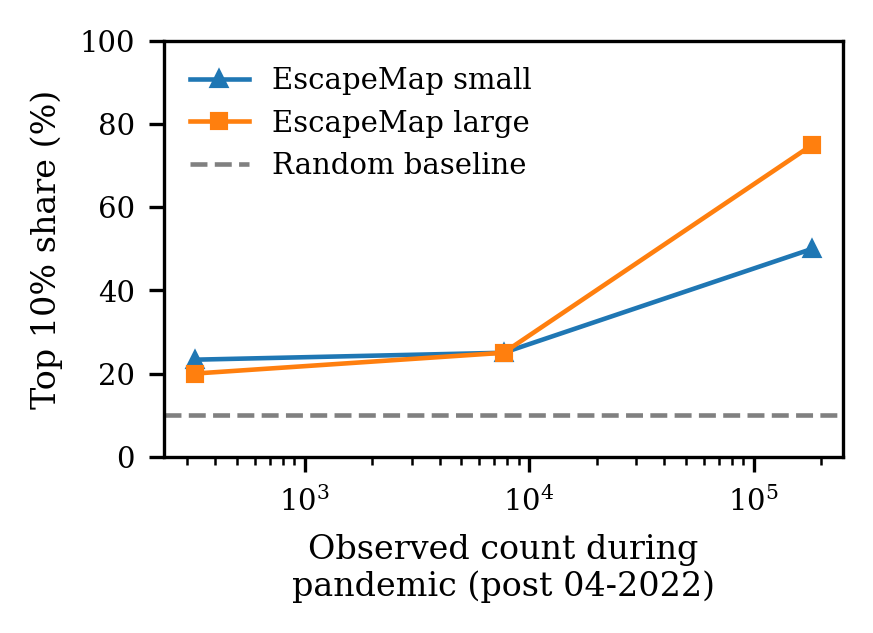

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import re


pat = re.compile(r"^([A-Z])(\d+)([A-Z])$")
def _parse_mut(m):
    if not isinstance(m, str):
        return pd.NA, pd.NA, pd.NA
    m = m.strip()
    mt = pat.match(m)
    if not mt:
        return pd.NA, pd.NA, pd.NA
    w, pos, mu = mt.groups()
    return w, int(pos), mu

am = all_mut.copy()
am["first_seen_100"] = pd.to_datetime(am["first_seen_100"], errors="coerce")
parsed = am["mutation"].apply(_parse_mut).apply(pd.Series)
parsed.columns = ["wt", "site", "mutant"]
am = pd.concat([am, parsed], axis=1).dropna(subset=["site", "mutant"]).copy()
am["site"]   = am["site"].astype("Int64")
am["mutant"] = am["mutant"].astype(str).str.strip()

# If duplicates exist for (site, mutant), keep earliest date and max count
am_collapsed = (
    am.groupby(["site", "mutant"], as_index=False)
      .agg(first_seen_100=("first_seen_100","min"),
           count_100=("count_100","max"))
)

# --- Prepare scores and choose columns ---
df = df_scores.copy()
df["site"]   = pd.to_numeric(df["site"], errors="coerce").astype("Int64")
df["mutant"] = df["mutant"].astype(str).str.strip()

candidate_cols = ["small","large"]
score_cols = [c for c in candidate_cols if c in df.columns]
if not score_cols:
    raise ValueError("No score columns found in df_scores. Expected any of: " + ", ".join(candidate_cols))

# --- Merge scores with epi info ---
merged = df.merge(am_collapsed, on=["site","mutant"], how="left", validate="m:1")

# --- Compute global 90th-percentile thresholds on full score distributions ---
thr = {c: np.nanpercentile(df[c].to_numpy(dtype=float), 90) for c in score_cols}

# --- Keep only mutations first seen >= 2022-01-01 ---
post2022 = merged.loc[merged["first_seen_100"] >= pd.Timestamp("2022-01-01")].copy()

# Guard: nothing to plot
if post2022.empty:
    raise RuntimeError("No mutations with first_seen_100 >= 2022-01-01 after merging. Check inputs.")

# --- Build count bins (log) spanning the data robustly ---
pos_counts = post2022["count_100"].dropna()
pos_counts = pos_counts[pos_counts > 0]
if pos_counts.empty:
    raise RuntimeError("No positive count_100 values post-2022.")

# Use a data-driven span with 7 bins (6 intervals)
lo, hi = float(pos_counts.min()), float(pos_counts.max())
# Expand bounds a bit for nicer bin edges
lo = max(1.0, lo / 1.5)
hi = hi * 1.5
bins = np.logspace(np.log10(lo), np.log10(hi), num=4)
post2022["count_bin"] = pd.cut(post2022["count_100"], bins=bins, include_lowest=True)

# --- For each bin & model: percentage in top 10% ---
def frac_top10(g, col, thr_val):
    vals = g[col].to_numpy(dtype=float)
    if vals.size == 0:
        return np.nan
    return np.nanmean(vals >= thr_val) * 100.0

rows = []
for b, g in post2022.groupby("count_bin", observed=True):
    if g.empty:
        continue
    # midpoint for plotting
    mid = np.sqrt(b.left * b.right) if pd.notna(b) else np.nan
    out = {"count_bin": b, "count_mid": mid, "n": len(g)}
    for c in score_cols:
        out[f"{c}_pct_top10"] = frac_top10(g, c, thr[c])
    rows.append(out)

bybin = pd.DataFrame(rows).sort_values("count_mid")

# ---------------- Nature-style plot ----------------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.1, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))

markers = ["^","s","o","D","v","x"]
for i, c in enumerate(score_cols):
    ax.plot(bybin["count_mid"], bybin[f"{c}_pct_top10"],
            marker=markers[i % len(markers)],
            label=c if c not in ["small","large"] else f"EscapeMap {c}")

ax.set_xscale("log")
ax.set_xlabel("Observed count during\npandemic (post 04-2022)")
ax.set_ylabel("Top 10% share (%)")
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.axhline(10, linestyle="--", label="Random baseline", color="grey")

# light cleanup
# for sp in ["top", "right"]:
#     ax.spines[sp].set_visible(False)
ax.legend(frameon=False, loc="best")

plt.tight_layout(pad=0.4)
plt.show()


# On JN1 background

In [17]:
JN1='SVYAWNRTRISNCVADYSVLYNFAPFFAFKCYGVSPTKLNDLCFTNVYADSFVIKGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKHSGNYDYWYRSFRKSKLKPFERDISTEIYQAGNKPCKGVKGPNCYFPLQSYGFRPTYGVGHQPYRVVVLSFELLHAPATVCG'
len(JN1)#it is actually BA2
JN1_SEQ=Proteins_utils.seq2num(JN1)
# run
write_single_mutants_fasta(JN1, out_path="../seq_data/JN1_single_mutants.fasta", prefix="JN1")


Wrote 3382 single mutants to ../seq_data/JN1_single_mutants.fasta


In [18]:
seqs_batch=Proteins_utils.load_FASTA("../seq_data/JN1_single_mutants.fasta")


In [19]:
import numpy as np
import pandas as pd


def generate_single_mutants(wt_seq, aa=AA):
    """Return metadata + seqs in the same order as your FASTA loop."""
    sites, mutants, seqs,wts = [],[], [], []
    for i, wt in enumerate(wt_seq, start=1):           # 1-based index
        if wt not in aa:
            continue
        for alt in aa:
            if alt == wt:
                continue
            sites.append(i+348)
            mutants.append(alt)
            wts.append(wt)
            seqs.append(wt_seq[:i-1] + alt + wt_seq[i:])
    return sites, mutants, seqs, wts

# Build batch
sites, mutants, _ , wts= generate_single_mutants(JN1)


# Assemble DataFrame and write CSV
df_scores = pd.DataFrame({
    "site": sites,
    "mutant": mutants,
    "wts": wts,

})

# Optional: sort by site then mutant for readability
df_scores.sort_values(["site", "mutant"], inplace=True, kind="mergesort")

df_scores

,site,mutant,wts
0,349,A,S
1,349,C,S
2,349,D,S
3,349,E,S
4,349,F,S
...,...,...,...
3377,526,S,G
3378,526,T,G
3379,526,V,G
3380,526,W,G


In [20]:
em_path = "../params_by_period_0.03_m1_m8_m8_full/param_period_2023-10-01.csv"
import torch
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS|BA1_KD_VECTORS)
model.raw_concentrations=model.raw_concentrations*0-12
model.raw_ace2=0
scores_diff=score_seq_batch(model, seqs_batch)+model(JN1_SEQ)
df_scores['rbm']=scores_diff


In [21]:
em_path = "../params_by_period_0.03_m1_m8_m8_full/param_period_2023-10-01.csv"
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS|BA1_KD_VECTORS)
model.raw_concentrations=model.raw_concentrations*0-12
model.raw_beta=-10

scores_diff=score_seq_batch(model, seqs_batch)+model(JN1_SEQ)
df_scores['ace2']=scores_diff


In [22]:
em_path = "../params_by_period_0.03_m1_m8_m8_full/param_period_2023-10-01.csv"
model=load_escape_map_from_csv(em_path, kd_vectors=KD_VECTORS|BA1_KD_VECTORS)
model.raw_ace2=0
model.raw_beta=-10
scores_diff=score_seq_batch(model, seqs_batch)+model(JN1_SEQ)
df_scores['ab']=scores_diff


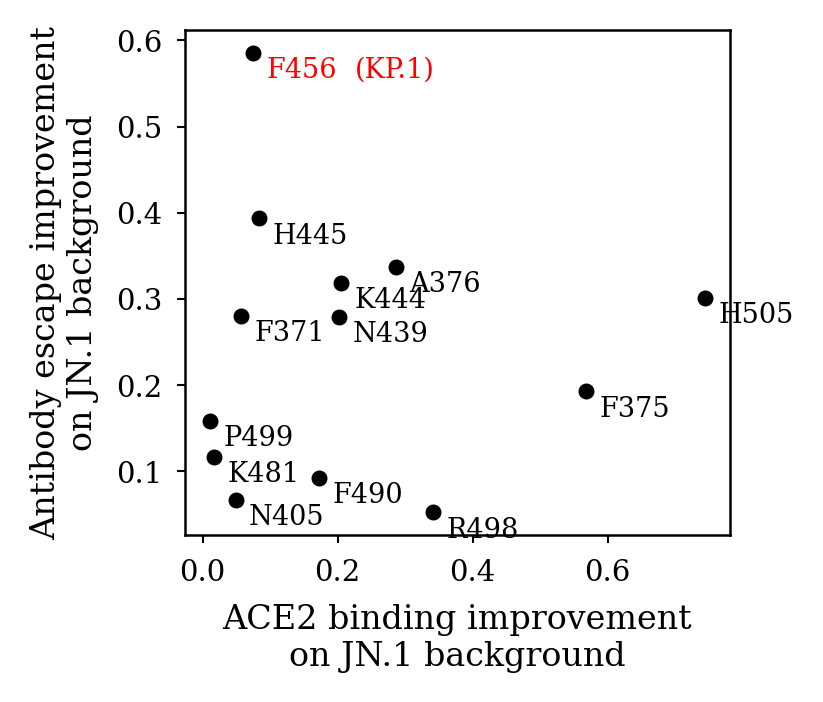

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = df_scores.copy()

# remove rows where both rbm < 0 and ace2 < 0
df = df[~((df["rbm"] < 0) | (df["ace2"] < 0) | (df["ab"] < 0))].copy()

df["total"] = df["ab"] + df["ace2"] + df["rbm"]

best_per_site = (
    df.sort_values("total", ascending=False)
      .groupby("site", as_index=False)
      .first()
)

top_sites = (
    best_per_site.nlargest(15, "ab")
    .sort_values("ab", ascending=False)
    .reset_index(drop=True)
)

# VOCs that emerged post-JN.1
sites_mutated_jn1 = {346: "KP.2", 456: "KP.1", 493: "KP.3"}

# -------------------------------------------------
# Nature-style figure
# -------------------------------------------------
plt.rcParams.update({
    "font.size": 7,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 6,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "axes.linewidth": 0.6,
    "lines.linewidth": 0.8,
})

fig, ax = plt.subplots(figsize=(2.6, 2.2), dpi=300)

# -------------------------------------------------
# Scatter map: Ab escape vs ACE2 binding
# -------------------------------------------------
ax.scatter(
    top_sites["ace2"],
    top_sites["ab"],
    color="black",
    s=8,
    zorder=2
)

# Annotate each site
for _, row in top_sites.iterrows():
    site = int(row["site"])
    wt = str(row["wts"])
    mut = f"{wt}{site}"

    # red if post-JN.1, black otherwise
    color = "red" if site in sites_mutated_jn1 else "black"
    ax.text(
        row["ace2"] + 0.02,  # small x offset
        row["ab"] - 0.02,    # small y offset
        mut,
        fontsize=6.5,
        color=color,
        ha="left",
        va="center",
        zorder=3
    )

    # If post-JN.1, add VOC name nearby
    if site in sites_mutated_jn1:
        ax.text(
            row["ace2"] + 0.15,
            row["ab"] - 0.02,
            '('+sites_mutated_jn1[site]+')',
            fontsize=6.5,
            color="red",
            ha="left",
            va="center",
            zorder=3
        )

# -------------------------------------------------
# Axes labels and style
# -------------------------------------------------
ax.set_xlabel("ACE2 binding improvement\non JN.1 background", fontsize=8)
ax.set_ylabel("Antibody escape improvement\non JN.1 background", fontsize=8)



# Clean Nature-style limits and ticks
ax.tick_params(length=2, width=0.5)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout(pad=0.3)
plt.show()
